In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# Complete clean dataset
# df = pd.read_csv('../datasets/filtered_dataset.csv')
# df.head()

In [7]:
# Clean dataset with outliers dropped
df = pd.read_csv('../datasets/filtered_dataset_dropout.csv')
df.head()

,Id,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,...,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010
0,109,6,1479,475.0,2.0,725.0,725,1976,2005,2,...,0,0,0,0,0,0,0,0,0,1
1,544,7,2122,559.0,2.0,913.0,913,1996,1997,2,...,1,0,0,0,0,0,0,0,1,0
2,153,5,1057,246.0,1.0,1057.0,1057,1953,2007,1,...,0,0,0,0,0,0,0,0,0,1
3,318,5,1444,400.0,2.0,384.0,744,2006,2007,2,...,1,0,0,0,0,0,0,0,0,1
4,255,6,1445,484.0,2.0,676.0,831,1900,1993,2,...,0,0,0,0,0,0,0,0,0,1


In [8]:
top_corr_reduced = df.corr().abs().drop(['Id','SalePrice'])[['SalePrice']].sort_values('SalePrice', ascending=False)

In [9]:
features = list(top_corr_reduced[top_corr_reduced > .5].dropna().drop(['Garage Yr Blt']).index)
features

['Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Exter Qual_TA',
 'Year Built',
 'Year Remod/Add',
 'Kitchen Qual_TA',
 'Full Bath',
 'Foundation_PConc',
 'Mas Vnr Area',
 'TotRms AbvGrd']

#### Begin: Utilizing methods described in regularization lecture

In [10]:
X = df[features] # Using raw top correlated variables for features to keep poly transform manageable
y = df['SalePrice']

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

X_overfit = poly.fit_transform(X)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Overall Qual      2019 non-null   int64  
 1   Gr Liv Area       2019 non-null   int64  
 2   Garage Area       2019 non-null   float64
 3   Garage Cars       2019 non-null   float64
 4   Total Bsmt SF     2019 non-null   float64
 5   1st Flr SF        2019 non-null   int64  
 6   Exter Qual_TA     2019 non-null   int64  
 7   Year Built        2019 non-null   int64  
 8   Year Remod/Add    2019 non-null   int64  
 9   Kitchen Qual_TA   2019 non-null   int64  
 10  Full Bath         2019 non-null   int64  
 11  Foundation_PConc  2019 non-null   int64  
 12  Mas Vnr Area      2019 non-null   float64
 13  TotRms AbvGrd     2019 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 221.0 KB


In [12]:
X_overfit_columns = poly.get_feature_names_out(X.columns)

In [13]:
X_overfit_columns.shape

(119,)

In [14]:
X_overfit.shape

(2019, 119)

In [15]:
X_poly = pd.DataFrame(X_overfit, columns=X_overfit_columns)

In [16]:
X_poly.head()

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Exter Qual_TA,Year Built,Year Remod/Add,Kitchen Qual_TA,...,Full Bath^2,Full Bath Foundation_PConc,Full Bath Mas Vnr Area,Full Bath TotRms AbvGrd,Foundation_PConc^2,Foundation_PConc Mas Vnr Area,Foundation_PConc TotRms AbvGrd,Mas Vnr Area^2,Mas Vnr Area TotRms AbvGrd,TotRms AbvGrd^2
0,6.0,1479.0,475.0,2.0,725.0,725.0,0.0,1976.0,2005.0,0.0,...,4.0,0.0,578.0,12.0,0.0,0.0,0.0,83521.0,1734.0,36.0
1,7.0,2122.0,559.0,2.0,913.0,913.0,0.0,1996.0,1997.0,0.0,...,4.0,2.0,264.0,16.0,1.0,132.0,8.0,17424.0,1056.0,64.0
2,5.0,1057.0,246.0,1.0,1057.0,1057.0,1.0,1953.0,2007.0,0.0,...,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,25.0
3,5.0,1444.0,400.0,2.0,384.0,744.0,1.0,2006.0,2007.0,1.0,...,4.0,2.0,0.0,14.0,1.0,0.0,7.0,0.0,0.0,49.0
4,6.0,1445.0,484.0,2.0,676.0,831.0,1.0,1900.0,1993.0,1.0,...,4.0,2.0,0.0,12.0,1.0,0.0,6.0,0.0,0.0,36.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)

In [18]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [19]:
l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(alphas=l_alphas)

lasso_cv.fit(Z_train, y_train)

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362795953499.311, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339849164876.83356, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329637009218.83325, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356288913103.86096, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356830288729.1993, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357346098538.8125, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366728491554.0293, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366799211795.96204, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366864518394.4006, tolerance: 695133878.4044044
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340611990309.29224, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339925372968.15375, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339977107169.0319, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360906937987.2309, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361537394966.8686, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362135561125.3864, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373156197070.8741, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373338774384.87463, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373519074521.40063, tolerance: 738261211.7881188
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345306505503.4088, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346610442075.94037, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347503534761.7336, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375810960008.6563, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376100962949.6189, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376375916841.59924, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380411556817.63226, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380463612613.7077, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380512708689.036, tolerance: 703891651.7364756
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320065306860.8014, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320291667175.106, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321045814383.67694, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354419749671.8572, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354977472691.3113, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355548488853.53937, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361805416355.433, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361845446394.5017, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361881547727.1854, tolerance: 692246785.3385293
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342247569552.8954, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343668664607.7642, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345391739729.4217, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381031946492.98846, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381658148894.6291, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382256867323.3156, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391071428927.1359, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391185226064.44525, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391291637073.29895, tolerance: 728273054.967797
  positive,
C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.736e+11, tolerance: 8.898e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [20]:
lasso_cv.alpha_

0.9326033468832199

In [21]:
lasso_coefs = lasso_cv.coef_

In [22]:
lasso_coefs = pd.Series(lasso_coefs, poly.get_feature_names_out(X.columns))

In [23]:
top_40 = lasso_coefs.abs().sort_values(ascending=False)[:40]

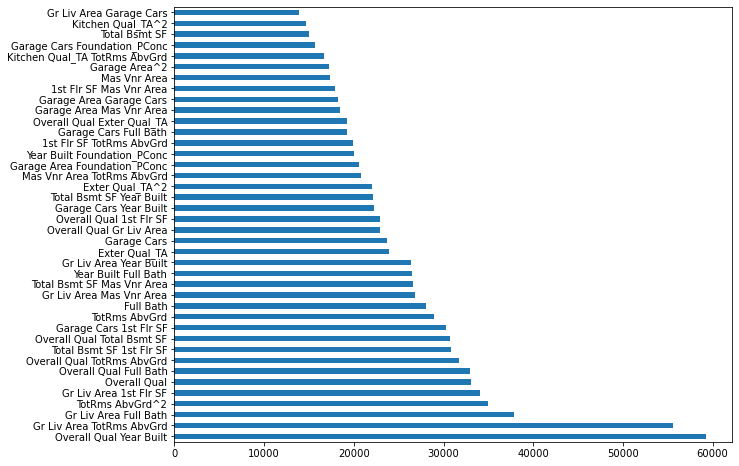

In [24]:
plt.figure(figsize=(10,8))
lasso_coefs.abs().sort_values(ascending=False)[:40].plot.barh();

In [25]:
features_poly = top_40.index

In [26]:
features_poly

Index(['Overall Qual Year Built', 'Gr Liv Area TotRms AbvGrd',
       'Gr Liv Area Full Bath', 'TotRms AbvGrd^2', 'Gr Liv Area 1st Flr SF',
       'Overall Qual', 'Overall Qual Full Bath', 'Overall Qual TotRms AbvGrd',
       'Total Bsmt SF 1st Flr SF', 'Overall Qual Total Bsmt SF',
       'Garage Cars 1st Flr SF', 'TotRms AbvGrd', 'Full Bath',
       'Gr Liv Area Mas Vnr Area', 'Total Bsmt SF Mas Vnr Area',
       'Year Built Full Bath', 'Gr Liv Area Year Built', 'Exter Qual_TA',
       'Garage Cars', 'Overall Qual Gr Liv Area', 'Overall Qual 1st Flr SF',
       'Garage Cars Year Built', 'Total Bsmt SF Year Built', 'Exter Qual_TA^2',
       'Mas Vnr Area TotRms AbvGrd', 'Garage Area Foundation_PConc',
       'Year Built Foundation_PConc', '1st Flr SF TotRms AbvGrd',
       'Garage Cars Full Bath', 'Overall Qual Exter Qual_TA',
       'Garage Area Mas Vnr Area', 'Garage Area Garage Cars',
       '1st Flr SF Mas Vnr Area', 'Mas Vnr Area', 'Garage Area^2',
       'Kitchen Qual_TA TotRms 

In [27]:
X_poly = X_poly[features_poly]
X_poly

,Overall Qual Year Built,Gr Liv Area TotRms AbvGrd,Gr Liv Area Full Bath,TotRms AbvGrd^2,Gr Liv Area 1st Flr SF,Overall Qual,Overall Qual Full Bath,Overall Qual TotRms AbvGrd,Total Bsmt SF 1st Flr SF,Overall Qual Total Bsmt SF,...,Garage Area Mas Vnr Area,Garage Area Garage Cars,1st Flr SF Mas Vnr Area,Mas Vnr Area,Garage Area^2,Kitchen Qual_TA TotRms AbvGrd,Garage Cars Foundation_PConc,Total Bsmt SF,Kitchen Qual_TA^2,Gr Liv Area Garage Cars
0,11856.0,8874.0,2958.0,36.0,1072275.0,6.0,12.0,36.0,525625.0,4350.0,...,137275.0,950.0,209525.0,289.0,225625.0,0.0,0.0,725.0,0.0,2958.0
1,13972.0,16976.0,4244.0,64.0,1937386.0,7.0,14.0,56.0,833569.0,6391.0,...,73788.0,1118.0,120516.0,132.0,312481.0,0.0,2.0,913.0,0.0,4244.0
2,9765.0,5285.0,1057.0,25.0,1117249.0,5.0,5.0,25.0,1117249.0,5285.0,...,0.0,246.0,0.0,0.0,60516.0,0.0,0.0,1057.0,0.0,1057.0
3,10030.0,10108.0,2888.0,49.0,1074336.0,5.0,10.0,35.0,285696.0,1920.0,...,0.0,800.0,0.0,0.0,160000.0,7.0,2.0,384.0,1.0,2888.0
4,11400.0,8670.0,2890.0,36.0,1200795.0,6.0,12.0,36.0,561756.0,4056.0,...,0.0,968.0,0.0,0.0,234256.0,6.0,2.0,676.0,1.0,2890.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,16056.0,12096.0,3456.0,49.0,2985984.0,8.0,16.0,56.0,3255552.0,15072.0,...,0.0,1040.0,0.0,0.0,270400.0,0.0,2.0,1884.0,0.0,3456.0
2015,7760.0,3444.0,861.0,16.0,741321.0,4.0,4.0,16.0,741321.0,3444.0,...,0.0,1078.0,0.0,0.0,290521.0,4.0,0.0,861.0,1.0,1722.0
2016,11568.0,17217.0,1913.0,81.0,2242036.0,6.0,6.0,54.0,1050112.0,5376.0,...,0.0,684.0,0.0,0.0,116964.0,9.0,0.0,896.0,1.0,3826.0
2017,7824.0,7200.0,1200.0,36.0,1440000.0,4.0,4.0,24.0,1440000.0,4800.0,...,0.0,294.0,0.0,0.0,86436.0,6.0,0.0,1200.0,1.0,1200.0


In [28]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, random_state=42)

#### End: Utilizing methods described in regularization lecture

In [29]:
X_train_poly

,Overall Qual Year Built,Gr Liv Area TotRms AbvGrd,Gr Liv Area Full Bath,TotRms AbvGrd^2,Gr Liv Area 1st Flr SF,Overall Qual,Overall Qual Full Bath,Overall Qual TotRms AbvGrd,Total Bsmt SF 1st Flr SF,Overall Qual Total Bsmt SF,...,Garage Area Mas Vnr Area,Garage Area Garage Cars,1st Flr SF Mas Vnr Area,Mas Vnr Area,Garage Area^2,Kitchen Qual_TA TotRms AbvGrd,Garage Cars Foundation_PConc,Total Bsmt SF,Kitchen Qual_TA^2,Gr Liv Area Garage Cars
1958,16032.0,20988.0,4664.0,81.0,2728440.0,8.0,16.0,72.0,1343160.0,9184.0,...,95256.0,2268.0,147420.0,126.0,571536.0,0.0,3.0,1148.0,0.0,6996.0
1879,16024.0,20547.0,4566.0,81.0,2301264.0,8.0,16.0,72.0,1016064.0,8064.0,...,118816.0,1896.0,189504.0,188.0,399424.0,0.0,3.0,1008.0,0.0,6849.0
944,7832.0,4800.0,960.0,25.0,921600.0,4.0,4.0,20.0,921600.0,3840.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,960.0,1.0,0.0
1160,9690.0,3544.0,886.0,16.0,784996.0,5.0,5.0,20.0,168340.0,950.0,...,0.0,273.0,0.0,0.0,74529.0,4.0,0.0,190.0,1.0,886.0
1571,9835.0,10206.0,1458.0,49.0,2125764.0,5.0,5.0,35.0,1714608.0,5880.0,...,230400.0,1024.0,656100.0,450.0,262144.0,7.0,0.0,1176.0,1.0,2916.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,9790.0,4560.0,912.0,25.0,831744.0,5.0,5.0,25.0,831744.0,4560.0,...,275.0,275.0,912.0,1.0,75625.0,5.0,0.0,912.0,1.0,912.0
1294,9640.0,12608.0,1576.0,64.0,1642192.0,5.0,5.0,40.0,1085764.0,5210.0,...,0.0,225.0,0.0,0.0,50625.0,8.0,0.0,1042.0,1.0,1576.0
860,9610.0,4080.0,816.0,25.0,665856.0,5.0,5.0,25.0,665856.0,4080.0,...,0.0,100.0,0.0,0.0,10000.0,5.0,0.0,816.0,1.0,816.0
1459,11868.0,8736.0,2912.0,36.0,1244880.0,6.0,12.0,36.0,731025.0,5130.0,...,0.0,880.0,0.0,0.0,193600.0,6.0,0.0,855.0,1.0,2912.0


In [30]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train_poly)

LinearRegression()

In [31]:
lr.score(X_train_poly, y_train_poly), lr.score(X_test_poly, y_test_poly)

(0.8740705950658392, 0.9024822733173063)

In [32]:
cross_val_score(lr, X_train_poly, y_train_poly).mean()

0.8536523806344676

In [33]:
pred = lr.predict(X_test_poly)

In [34]:
resid = y_test - pred

<AxesSubplot:>

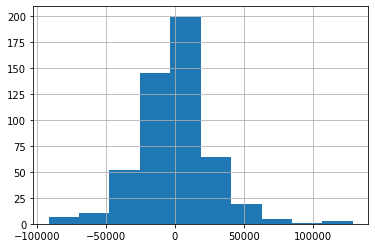

In [35]:
resid.hist()

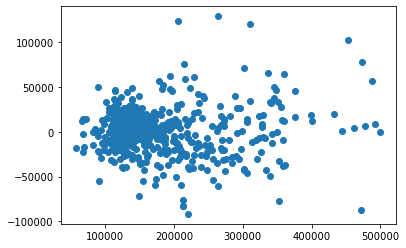

In [36]:
plt.scatter(pred, resid);

In [37]:
X_poly_corr = X_train_poly.join(y_train_poly).corr()['SalePrice'].sort_values(ascending=False)[1:]
X_poly_corr[X_poly_corr > .7]

Overall Qual Gr Liv Area      0.816811
Overall Qual Year Built       0.797236
Overall Qual                  0.790712
Overall Qual TotRms AbvGrd    0.785112
Gr Liv Area Garage Cars       0.777655
Overall Qual Full Bath        0.754641
Overall Qual 1st Flr SF       0.754575
Garage Cars 1st Flr SF        0.727177
Overall Qual Total Bsmt SF    0.723894
Garage Cars Full Bath         0.707162
Gr Liv Area Year Built        0.702585
Name: SalePrice, dtype: float64

In [38]:
res_std = resid.std()
res_std

26986.509534332094

In [39]:
res_mean = resid.mean()
res_mean

506.78062538789237

In [40]:
res_best = resid.abs().sort_values()[:10].index
res_best

Int64Index([1034, 1466, 1985, 809, 351, 788, 1826, 247, 450, 485], dtype='int64')

In [41]:
res_outliers_upper = resid[resid > (res_mean + 3 * res_std)]
res_outliers_upper.sort_values(ascending=False)

1729    129073.455654
453     123776.695255
322     120296.372752
1146    102456.876862
Name: SalePrice, dtype: float64

In [42]:
res_outliers_lower = resid[resid < (res_mean - 3 * res_std)]
res_outliers_lower.sort_values()

1668   -91722.274898
670    -87191.846063
65     -83196.020522
859    -83136.212324
Name: SalePrice, dtype: float64

### Feature Refinement

In [43]:
# From https://www.statology.org/how-to-calculate-vif-in-python/
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train_poly.values, i) 
              for i in range(X_train_poly.shape[1])]
vif['variable'] = X_train_poly.columns

C:\Users\musou\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [44]:
vif.sort_values(by='VIF', ascending=False)[:10]

,VIF,variable
17,inf,Exter Qual_TA
23,inf,Exter Qual_TA^2
0,1.421768e+05,Overall Qual Year Built
5,1.386798e+05,Overall Qual
22,1.119137e+05,Total Bsmt SF Year Built
37,1.061455e+05,Total Bsmt SF
15,9.457680e+04,Year Built Full Bath
12,8.982217e+04,Full Bath
21,7.991789e+04,Garage Cars Year Built
18,7.505835e+04,Garage Cars


In [54]:
# Select high vif columns for removal
vif_remove = ['Exter Qual_TA', 'Exter Qual_TA^2', 'Year Built Full Bath', 
              'Garage Cars', 'Overall Qual', 'TotRms AbvGrd', 'TotRms AbvGrd^2', 
              'Total Bsmt SF']

#### Iterative process for whittling down high vif columns

In [55]:
X_train_poly_drop = X_train_poly.drop(vif_remove, axis=1)
X_train_poly_drop

,Overall Qual Year Built,Gr Liv Area TotRms AbvGrd,Gr Liv Area Full Bath,Gr Liv Area 1st Flr SF,Overall Qual Full Bath,Overall Qual TotRms AbvGrd,Total Bsmt SF 1st Flr SF,Overall Qual Total Bsmt SF,Garage Cars 1st Flr SF,Full Bath,...,Overall Qual Exter Qual_TA,Garage Area Mas Vnr Area,Garage Area Garage Cars,1st Flr SF Mas Vnr Area,Mas Vnr Area,Garage Area^2,Kitchen Qual_TA TotRms AbvGrd,Garage Cars Foundation_PConc,Kitchen Qual_TA^2,Gr Liv Area Garage Cars
1958,16032.0,20988.0,4664.0,2728440.0,16.0,72.0,1343160.0,9184.0,3510.0,2.0,...,0.0,95256.0,2268.0,147420.0,126.0,571536.0,0.0,3.0,0.0,6996.0
1879,16024.0,20547.0,4566.0,2301264.0,16.0,72.0,1016064.0,8064.0,3024.0,2.0,...,0.0,118816.0,1896.0,189504.0,188.0,399424.0,0.0,3.0,0.0,6849.0
944,7832.0,4800.0,960.0,921600.0,4.0,20.0,921600.0,3840.0,0.0,1.0,...,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0
1160,9690.0,3544.0,886.0,784996.0,5.0,20.0,168340.0,950.0,886.0,1.0,...,5.0,0.0,273.0,0.0,0.0,74529.0,4.0,0.0,1.0,886.0
1571,9835.0,10206.0,1458.0,2125764.0,5.0,35.0,1714608.0,5880.0,2916.0,1.0,...,5.0,230400.0,1024.0,656100.0,450.0,262144.0,7.0,0.0,1.0,2916.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,9790.0,4560.0,912.0,831744.0,5.0,25.0,831744.0,4560.0,912.0,1.0,...,5.0,275.0,275.0,912.0,1.0,75625.0,5.0,0.0,1.0,912.0
1294,9640.0,12608.0,1576.0,1642192.0,5.0,40.0,1085764.0,5210.0,1042.0,1.0,...,5.0,0.0,225.0,0.0,0.0,50625.0,8.0,0.0,1.0,1576.0
860,9610.0,4080.0,816.0,665856.0,5.0,25.0,665856.0,4080.0,816.0,1.0,...,5.0,0.0,100.0,0.0,0.0,10000.0,5.0,0.0,1.0,816.0
1459,11868.0,8736.0,2912.0,1244880.0,12.0,36.0,731025.0,5130.0,1710.0,2.0,...,0.0,0.0,880.0,0.0,0.0,193600.0,6.0,0.0,1.0,2912.0


In [56]:
len(X_train_poly_drop.values[0]), X_train_poly_drop.shape[1]

(32, 32)

In [57]:
# Looking at vif with identified columns removed
vif2 = pd.DataFrame()
vif2['VIF'] = [variance_inflation_factor(X_train_poly_drop.values, i) 
              for i in range(X_train_poly_drop.shape[1])]
vif2['variable'] = X_train_poly_drop.columns

In [58]:
vif2.sort_values(by='VIF', ascending=False)[:10]

,VIF,variable
13,964.694335,Overall Qual Gr Liv Area
5,617.146766,Overall Qual TotRms AbvGrd
12,584.962100,Gr Liv Area Year Built
20,543.053422,1st Flr SF TotRms AbvGrd
4,535.242229,Overall Qual Full Bath
14,465.575259,Overall Qual 1st Flr SF
0,414.387951,Overall Qual Year Built
7,392.808744,Overall Qual Total Bsmt SF
9,351.925328,Full Bath
1,342.113854,Gr Liv Area TotRms AbvGrd


In [59]:
# Reminding myself what my top features are for correlation
X_poly_corr[X_poly_corr > .5]

Overall Qual Gr Liv Area        0.816811
Overall Qual Year Built         0.797236
Overall Qual                    0.790712
Overall Qual TotRms AbvGrd      0.785112
Gr Liv Area Garage Cars         0.777655
Overall Qual Full Bath          0.754641
Overall Qual 1st Flr SF         0.754575
Garage Cars 1st Flr SF          0.727177
Overall Qual Total Bsmt SF      0.723894
Garage Cars Full Bath           0.707162
Gr Liv Area Year Built          0.702585
Gr Liv Area Full Bath           0.679577
Garage Area Foundation_PConc    0.676655
Garage Area Garage Cars         0.672126
Garage Cars Foundation_PConc    0.659386
Garage Cars Year Built          0.647249
Garage Cars                     0.635944
Garage Area^2                   0.620973
Gr Liv Area TotRms AbvGrd       0.597615
Total Bsmt SF Year Built        0.595704
Total Bsmt SF                   0.584128
1st Flr SF TotRms AbvGrd        0.583207
Gr Liv Area 1st Flr SF          0.570671
Year Built Full Bath            0.558765
Full Bath       

### Pair down training features according to vif iterations

In [60]:
lr_poly_drop = LinearRegression()
lr_poly_drop.fit(X_train_poly_drop, y_train)

LinearRegression()

In [61]:
cross_val_score(lr_poly_drop, X_train_poly_drop, y_train).mean()

0.8454537254555075

In [62]:
X_test_poly_drop = X_test_poly[X_train_poly_drop.columns]

In [63]:
pred_poly_drop = lr_poly_drop.predict(X_test_poly_drop)

In [64]:
lr_poly_drop.score(X_train_poly_drop, y_train)

0.8645070217227486

In [65]:
lr_poly_drop.score(X_test_poly_drop, y_test)

0.898507674887395

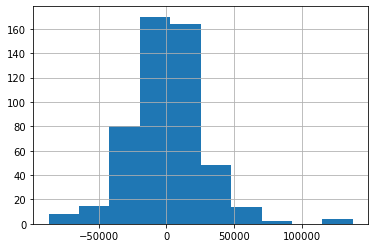

In [66]:
resid_poly_drop = y_test - pred_poly_drop
resid_poly_drop.hist();

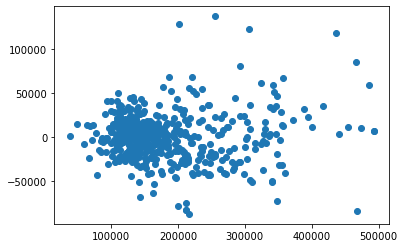

In [67]:
plt.scatter(pred_poly_drop, resid_poly_drop);

### Feature Engineering

In [68]:
X_poly_drop_corr = X_train_poly_drop.join(y_train).corr()['SalePrice'].sort_values(ascending=False)[1:]
X_poly_drop_corr[X_poly_drop_corr > .5]

Overall Qual Gr Liv Area        0.816811
Overall Qual Year Built         0.797236
Overall Qual TotRms AbvGrd      0.785112
Gr Liv Area Garage Cars         0.777655
Overall Qual Full Bath          0.754641
Overall Qual 1st Flr SF         0.754575
Garage Cars 1st Flr SF          0.727177
Overall Qual Total Bsmt SF      0.723894
Garage Cars Full Bath           0.707162
Gr Liv Area Year Built          0.702585
Gr Liv Area Full Bath           0.679577
Garage Area Foundation_PConc    0.676655
Garage Area Garage Cars         0.672126
Garage Cars Foundation_PConc    0.659386
Garage Cars Year Built          0.647249
Garage Area^2                   0.620973
Gr Liv Area TotRms AbvGrd       0.597615
Total Bsmt SF Year Built        0.595704
1st Flr SF TotRms AbvGrd        0.583207
Gr Liv Area 1st Flr SF          0.570671
Full Bath                       0.544517
Garage Area Mas Vnr Area        0.542672
Year Built Foundation_PConc     0.539328
Mas Vnr Area TotRms AbvGrd      0.502226
Name: SalePrice,

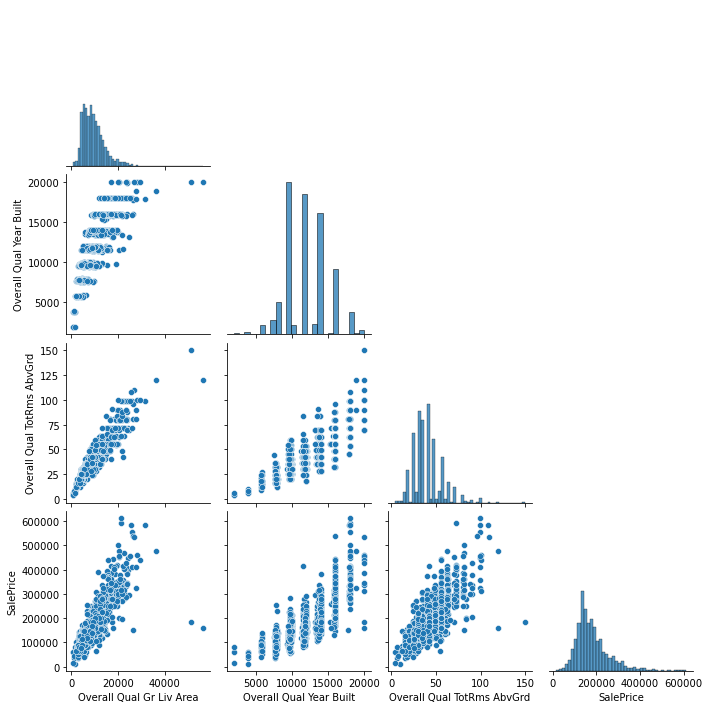

In [69]:
sns.pairplot(X_train_poly_drop[X_poly_drop_corr.index[:3]].join(y_train), corner=True, palette='Blues')

(                         Overall Qual Year Built  SalePrice
 Overall Qual Year Built                 1.000000   0.819456
 SalePrice                               0.819456   1.000000,
                          Overall Qual Year Built  SalePrice
 Overall Qual Year Built                 1.000000   0.819237
 SalePrice                               0.819237   1.000000)

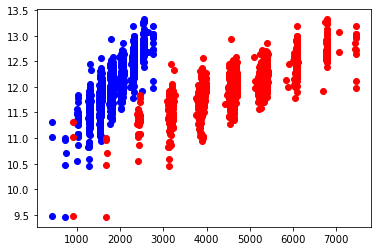

In [70]:
feature = 'Overall Qual Year Built'
feature_mod = X_train_poly_drop[feature].map(lambda x: x ** .8)
target_mod = y_train.map(lambda x: np.log(x))
feature_mod_2 = X_train_poly_drop[feature].map(lambda x: x ** .9)
target_mod_2 = y_train.map(lambda x: np.log(x))
plt.scatter(feature_mod, target_mod, c='b')
plt.scatter(feature_mod_2, target_mod_2, c='r');
feature_mod.to_frame().join(target_mod).corr(),feature_mod_2.to_frame().join(target_mod_2).corr()

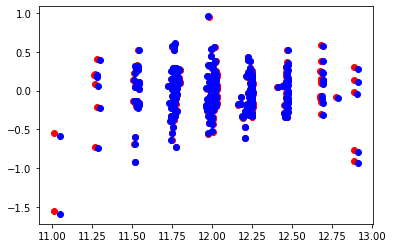

In [71]:
lr_mod = LinearRegression()
X_mod_train, X_mod_test, y_mod_train, y_mod_test = train_test_split(feature_mod.to_frame(), target_mod, random_state=42)
lr_mod.fit(X_mod_train, y_mod_train)
pred_mod = lr_mod.predict(X_mod_test)
resid_mod = y_mod_test - pred_mod
lr_mod_2 = LinearRegression()
X_mod_train_2, X_mod_test_2, y_mod_train_2, y_mod_test_2 = train_test_split(feature_mod_2.to_frame(), target_mod_2, random_state=42)
lr_mod_2.fit(X_mod_train_2, y_mod_train_2)
pred_mod_2 = lr_mod_2.predict(X_mod_test_2)
resid_mod_2 = y_mod_test_2 - pred_mod_2
plt.scatter(pred_mod, resid_mod, c='r')
plt.scatter(pred_mod_2, resid_mod_2, c='b')

In [72]:
# Modified 'Overall Qual Year Built' for better correlation with log('SalePrice')
X_train_poly_drop['Overall Qual Year Built_mod'] = X_train_poly_drop['Overall Qual Year Built'].map(lambda x: x ** .8)
X_test_poly_drop['Overall Qual Year Built_mod'] = X_test_poly_drop['Overall Qual Year Built'].map(lambda x: x ** .8)

C:\Users\musou\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
X_train_poly_drop.head()

,Overall Qual Year Built,Gr Liv Area TotRms AbvGrd,Gr Liv Area Full Bath,Gr Liv Area 1st Flr SF,Overall Qual Full Bath,Overall Qual TotRms AbvGrd,Total Bsmt SF 1st Flr SF,Overall Qual Total Bsmt SF,Garage Cars 1st Flr SF,Full Bath,...,Garage Area Mas Vnr Area,Garage Area Garage Cars,1st Flr SF Mas Vnr Area,Mas Vnr Area,Garage Area^2,Kitchen Qual_TA TotRms AbvGrd,Garage Cars Foundation_PConc,Kitchen Qual_TA^2,Gr Liv Area Garage Cars,Overall Qual Year Built_mod
1958,16032.0,20988.0,4664.0,2728440.0,16.0,72.0,1343160.0,9184.0,3510.0,2.0,...,95256.0,2268.0,147420.0,126.0,571536.0,0.0,3.0,0.0,6996.0,2312.012423
1879,16024.0,20547.0,4566.0,2301264.0,16.0,72.0,1016064.0,8064.0,3024.0,2.0,...,118816.0,1896.0,189504.0,188.0,399424.0,0.0,3.0,0.0,6849.0,2311.089418
944,7832.0,4800.0,960.0,921600.0,4.0,20.0,921600.0,3840.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,1303.461305
1160,9690.0,3544.0,886.0,784996.0,5.0,20.0,168340.0,950.0,886.0,1.0,...,0.0,273.0,0.0,0.0,74529.0,4.0,0.0,1.0,886.0,1545.464458
1571,9835.0,10206.0,1458.0,2125764.0,5.0,35.0,1714608.0,5880.0,2916.0,1.0,...,230400.0,1024.0,656100.0,450.0,262144.0,7.0,0.0,1.0,2916.0,1563.937853


In [74]:
X_test_poly_drop.head()

,Overall Qual Year Built,Gr Liv Area TotRms AbvGrd,Gr Liv Area Full Bath,Gr Liv Area 1st Flr SF,Overall Qual Full Bath,Overall Qual TotRms AbvGrd,Total Bsmt SF 1st Flr SF,Overall Qual Total Bsmt SF,Garage Cars 1st Flr SF,Full Bath,...,Garage Area Mas Vnr Area,Garage Area Garage Cars,1st Flr SF Mas Vnr Area,Mas Vnr Area,Garage Area^2,Kitchen Qual_TA TotRms AbvGrd,Garage Cars Foundation_PConc,Kitchen Qual_TA^2,Gr Liv Area Garage Cars,Overall Qual Year Built_mod
1556,15992.0,18920.0,4730.0,2998820.0,16.0,64.0,1587536.0,10016.0,3804.0,2.0,...,576088.0,2568.0,853364.0,673.0,732736.0,0.0,3.0,0.0,7095.0,2307.396475
526,14035.0,12565.0,3590.0,1577805.0,14.0,49.0,772641.0,6153.0,1758.0,2.0,...,0.0,1156.0,0.0,0.0,334084.0,0.0,2.0,0.0,3590.0,2078.595265
393,11550.0,8214.0,2738.0,954193.0,12.0,36.0,468384.0,4032.0,697.0,2.0,...,0.0,300.0,0.0,0.0,90000.0,6.0,0.0,1.0,1369.0,1778.547987
1789,18072.0,14128.0,3532.0,3118756.0,18.0,72.0,3092266.0,15759.0,5298.0,2.0,...,351348.0,2622.0,709932.0,402.0,763876.0,0.0,3.0,0.0,5298.0,2544.514759
433,9915.0,3264.0,816.0,665856.0,5.0,20.0,665856.0,4080.0,816.0,1.0,...,0.0,264.0,0.0,0.0,69696.0,4.0,0.0,1.0,816.0,1574.106727


In [75]:
lr_log_poly_drop = LinearRegression()
lr_log_poly_drop.fit(X_train_poly_drop, y_train.map(np.log))

LinearRegression()

In [76]:
cross_val_score(lr_log_poly_drop, X_train_poly_drop, y_train.map(np.log)).mean()

0.8250421072343641

In [77]:
pred_log_poly_drop = lr_log_poly_drop.predict(X_test_poly_drop)

In [78]:
lr_log_poly_drop.score(X_train_poly_drop, y_train.map(np.log))

0.838265397594329

In [79]:
lr_log_poly_drop.score(X_test_poly_drop, y_test.map(np.log))

0.8848347094605803

In [80]:
resid_log_poly_drop = y_test.map(np.log) - pred_log_poly_drop

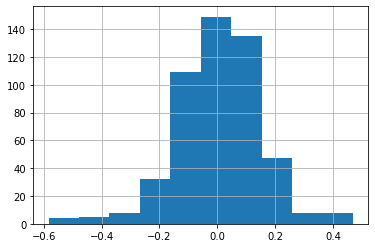

In [81]:
resid_log_poly_drop.hist();

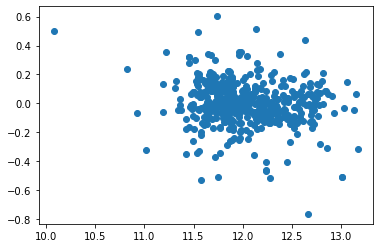

In [743]:
plt.scatter(pred_log_poly_drop, resid_log_poly_drop);

### Process Submission Data

In [ ]:
df_kaggle = pd.read_csv('../datasets/filtered_test_dataset.csv')
df_kaggle.info()

In [ ]:
X_kaggle = df_kaggle[features].copy()

In [ ]:
X_kaggle.info()

In [ ]:
imp_most = SimpleImputer(strategy='most_frequent')
imp_most.fit(df[features])

In [ ]:
imputed_values = imp_most.transform(X_kaggle)

In [ ]:
imputed_X_kaggle = pd.DataFrame(imputed_values, columns=X_kaggle.columns)

In [ ]:
imputed_X_kaggle.isnull().sum().sum()

In [ ]:
X_overfit_kaggle = poly.transform(imputed_X_kaggle)

In [ ]:
X_overfit_kaggle_columns = poly.get_feature_names_out(imputed_X_kaggle.columns)

In [ ]:
X_poly_kaggle = pd.DataFrame(X_overfit_kaggle, columns=X_overfit_kaggle_columns)

In [ ]:
X_poly_kaggle = X_poly_kaggle[features_poly]
X_poly_kaggle.info()

In [ ]:
# Custom engineered features
X_poly_kaggle['Overall Qual Year Built_mod'] = X_poly_kaggle['Overall Qual Year Built'].map(lambda x: x ** .8)

In [ ]:
X_poly_drop_kaggle = X_poly_kaggle[X_train_poly_drop.columns]
X_poly_drop_kaggle.info()

In [ ]:
X_train_poly_drop.info()

In [ ]:
# pred_kaggle = lr_log_poly_drop.predict(X_poly_kaggle)

In [ ]:
pred_log_poly_drop_kaggle = lr_log_poly_drop.predict(X_poly_drop_kaggle)

In [ ]:
# Option 1 - basic highest correlation features
# df_kaggle['SalePrice'] = pred_kaggle
# df_kaggle['SalePrice'].head()

# Option 2 - polynomial features
# df_kaggle['SalePrice'] = pred_poly_drop_kaggle
# df_kaggle['SalePrice'].head()

# Option 3 - np.log
df_kaggle['SalePrice'] = pred_log_poly_drop_kaggle
df_kaggle['SalePrice'] = df_kaggle['SalePrice'].map(np.exp)
df_kaggle['SalePrice'].head()

In [ ]:
submission = df_kaggle[['Id', 'SalePrice']]
submission.set_index('Id', inplace=True)
submission

In [630]:
submission.to_csv('../outputs/mlr_15_submission.csv')